# Library, def, class

In [1]:
# ! pip install lightgbm
# ! pip install catboost
# ! pip install mlxtend
# ! pip install scikit-feature

In [2]:
import pandas as pd
import numpy as np
import os

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, VotingRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMRegressor
import xgboost as xgb

from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, GridSearchCV, cross_val_score, cross_val_predict
 
import seaborn as sns
import matplotlib.pyplot as plt
 
from sklearn.metrics import r2_score, roc_auc_score

from sklearn.decomposition import PCA, TruncatedSVD 

from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler, OneHotEncoder

from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, RFECV
from mlxtend.feature_selection import SequentialFeatureSelector

import os

pd.set_option('display.max_rows', 500)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# FeatureSelect

In [3]:
class Feature_Selection():

  def Univariate(self, strategy, X_train, y_train, down, up, k, feature, price = 'Price'):
    if strategy == 'corr':
      X_train = X_train[feature + [price]]
      corr = X_train[X_train.columns[X_train.isna().sum() == 0]].corr()[[price]].sort_values(price)
      corr_feature = (corr[(corr[price] < down) | (corr[price] > up)])
      corr_feature = corr_feature.index
      corr_feature = corr_feature.drop(price)
      self.X_train_corr = X_train[corr_feature]

    if strategy == 'SelectKBest':
      X_train = X_train[feature]
      X_train = X_train[X_train.columns[X_train.isna().sum() == 0]]
      self.X_train_SelectKBest = SelectKBest(mutual_info_regression, k = k).fit_transform(X_train.iloc[:,:], y_train)

    if strategy == 'info':
      pass

  def drop_correl_columns(self, DATA, corr = 0.8):
    correlated_features = set()
    correlation_matrix = DATA.corr()
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > corr:
                colname = correlation_matrix.columns[i]
                correlated_features.add(colname)


    self.data_no_corr = DATA.drop(labels=correlated_features, axis=1, inplace=True)
    # test_features.drop(labels=correlated_features, axis=1, inplace=True)

  def wrap(self, type_, train, train_labels):
    
    feature_selector = SequentialFeatureSelector(RandomForestRegressor(n_jobs = -1),
           k_features=5,
           forward = True,
           verbose=2,
           scoring='r2',
           cv=4)
    features = feature_selector.fit(train.fillna(0), train_labels)
    filtered_features= train.columns[list(features.k_feature_idx_)]
    self.RF_feature = train[filtered_features]


  def rfecv(self, X_train, y_train):
    rfecv = RFECV(estimator = RandomForestRegressor(n_jobs = -1), step = 1, cv = 4, scoring = 'r2')
    rfecv = rfecv.fit(X_train, y_train)
    # rfecv.n_features_
    self.rfecv = X_train[X_train.columns[rfecv.support_]]
    # rfecv.grid_scores_


# Корректировка данных

In [4]:
def init(train):

  train['errorSquare'] = np.where(train['Square'] < train['LifeSquare'], 1, 0) 
  train['errorFloor']  = np.where(train['HouseFloor'] < train['Floor'], 1, 0) 

  train['HouseYear'] = np.where(train['HouseYear'] == 4968, 1968, np.where(train['HouseYear'] == 20052011, 2011, train['HouseYear']))

  train['floorFirsLast'] = np.where(train['Floor'] == 1, 1, 0)

  history = pd.DataFrame(train[train['HouseYear'] < 1952]['DistrictId'].value_counts())
  train['historyDistrict'] = np.where(train['DistrictId'].isin(history.index), 1, 0)

  train['Shops_1Fix'] = np.where(train['DistrictId'] == 30, 0, train['Shops_1'])
  train['Shops_3'] = np.where(train['Shops_2'] == 0, train['Shops_1Fix'] - 1, train['Shops_1Fix'])

  train['HouseYearFix'] = np.where(train['HouseYear'] > 1957, train['HouseYear'], train['HouseYear']//10*10)
  train['HouseYearFix'] = np.where(train['HouseYear'] < 1920, 1910, train['HouseYearFix'])

  train['HouseFloorFix'] = np.where(train['errorFloor'] == 1, round(train['Floor']*1.6, 0), train['HouseFloor'])
  train['RelativeFloor'] = np.where(train['Floor']/train['HouseFloorFix'] < 0.33, - 1, np.where(train['Floor']/train['HouseFloorFix'] > 0.66, 1, 0))

  train['Healthcare1Empty'] = np.where(train['Healthcare_1'].isna(), 1, 0)

  train['RoomsFix'] = np.where(train['Rooms'] == 0, 4, np.where(train['Rooms'] > 4, 4, train['Rooms']))

  train['roomSquare'] = train['Square']/train['RoomsFix']

  train['Square'] = np.where(train['Square'] > 300, train['Square']/10, train['Square'])
  train['Square'] = np.where(train['Square'] > 10, train['Square'], np.where(train['Square'] > 2, train['Square']*10,  train['Square']*100))  
  
  train['Unique']  = train['DistrictId'] * 1000000 + train['HouseYear'] * 100 + train['HouseFloor']
  train['Unique1'] = train['DistrictId'] * 1000000 + train['HouseYear'] * 1 + train['HouseFloor']*10000
  train['Unique2'] = train['DistrictId']  + train['HouseYear'] * 1000000 + train['HouseFloor']*1000
  train['Unique3'] = train['DistrictId']  + train['HouseYear'] * 1000 + train['HouseFloor']*1000000
  train['Unique4'] = train['DistrictId'] *10000 + train['HouseYear'] * 1 + train['HouseFloor']*1000000
  train['Unique5'] = train['DistrictId'] *10000 + train['HouseYear'] * 1 
  
  train['LifeSquareFix'] = np.where(train['LifeSquare'].isna(), train['Square']*0.62, train['LifeSquare'])

  train['ShareLife'] = train['LifeSquareFix']/train['Square']

  train['Rooms_Outer'] = train['RoomsFix'] - train['RoomsFix'].mean()

  train['Square_Outer'] = train['Square'] - train['Square'].mean()

  train['price1Square'] = train['Price']/train['Square']

  train['errorSquare_now'] = np.where(train['Square'] <= 1.5*train['KitchenSquare'], 1, 0)
  train['KitchenSquare_fix'] = np.where(train['errorSquare_now'] == 1, train['Square']/1.5, \
                                                    train['KitchenSquare'])

  # #РАсширяем дистрикты проба 
  # district_160,district_153,district_195,district_208 = {160, 16, 136}, {153, 149, 110}, {195, 172}, {192, 193, 194, 131, 165, 166, 137, 141, 208, 50, 115, 114, 152, 127}
  # for i, ii in zip([160,153,195,208], [district_160,district_153,district_195,district_208]):
  #   train['DistrictId'] = np.where(train['DistrictId'].isin(list(ii)), i, train['DistrictId'])
  
  return train

In [5]:
def init_for_test(train):

  train['errorSquare'] = np.where(train['Square'] < train['LifeSquare'], 1, 0) 
  train['errorFloor']  = np.where(train['HouseFloor'] < train['Floor'], 1, 0) 

  train['HouseYear'] = np.where(train['HouseYear'] == 4968, 1968, np.where(train['HouseYear'] == 20052011, 2011, train['HouseYear']))

  train['floorFirsLast'] = np.where(train['Floor'] == 1, 1, 0)

  history = pd.DataFrame(train[train['HouseYear'] < 1952]['DistrictId'].value_counts())
  train['historyDistrict'] = np.where(train['DistrictId'].isin(history.index), 1, 0)

  train['Shops_1Fix'] = np.where(train['DistrictId'] == 30, 0, train['Shops_1'])
  train['Shops_3'] = np.where(train['Shops_2'] == 0, train['Shops_1Fix'] - 1, train['Shops_1Fix'])

  train['HouseYearFix'] = np.where(train['HouseYear'] > 1957, train['HouseYear'], train['HouseYear']//10*10)
  train['HouseYearFix'] = np.where(train['HouseYear'] < 1920, 1910, train['HouseYearFix'])

  train['HouseFloorFix'] = np.where(train['errorFloor'] == 1, round(train['Floor']*1.6, 0), train['HouseFloor'])
  train['RelativeFloor'] = np.where(train['Floor']/train['HouseFloorFix'] < 0.33, - 1, np.where(train['Floor']/train['HouseFloorFix'] > 0.66, 1, 0))

  train['Healthcare1Empty'] = np.where(train['Healthcare_1'].isna(), 1, 0)

  train['RoomsFix'] = np.where(train['Rooms'] == 0, 4, np.where(train['Rooms'] > 4, 4, train['Rooms']))

  train['roomSquare'] = train['Square']/train['RoomsFix']

  train['Square'] = np.where(train['Square'] > 300, train['Square']/10, train['Square'])
  train['Square'] = np.where(train['Square'] > 10, train['Square'], np.where(train['Square'] > 2, train['Square']*10,  train['Square']*100))

  train['Unique']  = train['DistrictId'] * 1000000 + train['HouseYear'] * 100 + train['HouseFloor']
  train['Unique1'] = train['DistrictId'] * 1000000 + train['HouseYear'] * 1 + train['HouseFloor']*10000
  train['Unique2'] = train['DistrictId']  + train['HouseYear'] * 1000000 + train['HouseFloor']*1000
  train['Unique3'] = train['DistrictId']  + train['HouseYear'] * 1000 + train['HouseFloor']*1000000
  train['Unique4'] = train['DistrictId'] *10000 + train['HouseYear'] * 1 + train['HouseFloor']*1000000
  train['Unique5'] = train['DistrictId'] *10000 + train['HouseYear'] * 1 
  
  train['LifeSquareFix'] = np.where(train['LifeSquare'].isna(), train['Square']*0.62, train['LifeSquare'])

  train['ShareLife'] = train['LifeSquareFix']/train['Square']

  train['Rooms_Outer'] = train['RoomsFix'] - train['RoomsFix'].mean()

  train['Square_Outer'] = train['Square'] - train['Square'].mean()

  train['errorSquare_now'] = np.where(train['Square'] <= 1.5*train['KitchenSquare'], 1, 0)
  train['KitchenSquare_fix'] = np.where(train['errorSquare_now'] == 1, train['Square']/1.5, \
                                                    train['KitchenSquare'])

  # train['price1Square'] = train['Price']/train['Square']

  # # #РАсширяем дистрикты проба
  # district_160,district_153,district_195,district_208 = {160, 16, 136}, {153, 149, 110}, {195, 172}, {192, 193, 194, 131, 165, 166, 137, 141, 208, 50, 115, 114, 152, 127}
  # for i, ii in zip([160,153,195,208], [district_160,district_153,district_195,district_208]):
  #   train['DistrictId'] = np.where(train['DistrictId'].isin(list(ii)), i, train['DistrictId'])

  # Special, Special
  train['DistrictId'] = np.where((train['DistrictId'] == 203)|(train['DistrictId'] == 211)|(train['DistrictId'] == 198), 84, train['DistrictId'])
  train['DistrictId'] = np.where((train['DistrictId'] == 212)|(train['DistrictId'] == 206)|(train['DistrictId'] == 204)|(train['DistrictId'] == 210), 8, train['DistrictId'])

  return train

In [6]:
def spleet_train_test_all(DATA, *args):
  all = pd.DataFrame()
  for arg in args:
    all = pd.concat([all, DATA[DATA['label'] == arg]])
  return all

def category(data, label, type_):
  # data = ob_train_train.X_train
  # label = 'DistrictId'
  # type_ = 'category'
  data[[label]] = data[[label]].astype(type_)

In [7]:
# quant_ = 'quant-DistrictId-Square-count'
# price_ = 'price1Square'
# DATA_ = ob_all.data
name = ""
# bins = 75
def plot_quant(quant_, price_, DATA_, name = name):
  plt.figure(figsize = (15, 8))  
  for i in (range(len(DATA_[quant_].unique()))):
    if len(quant_.split('-')) > 2:
      for_ii = '-'.join(quant_.split('-')[1:])
    else:
      for_ii = quant_.split('-')[-1]
    # print(for_ii)
    ii = round(DATA_[DATA_[quant_] == i][for_ii].mean(), 2)
    data = DATA_[DATA_[quant_] == i][price_]
    plt.hist(data, bins = bins, alpha = 0.95, label = ii)
    plt.title(str(name) + price_ + '___for:' + quant_)
    plt.legend()
    plt.xlim(1000, 7000)
    
  plt.show()

def plot_quant_one(quant_, price_, DATA_, name = name):
  fig, axs = plt.subplots(len(DATA_[quant_].unique()), 1)
  fig.set_size_inches(10, 10)
  fig.subplots_adjust(wspace = 0.5, hspace = 0.5)
  
  for i in (range(len(DATA_[quant_].unique()))):
    if len(quant_.split('-')) > 2:
      for_ii = '-'.join(quant_.split('-')[1:])
    else:
      for_ii = quant_.split('-')[-1]
    ii = round(DATA_[DATA_[quant_] == i][for_ii].mean(), 2)
    # # # display('Square со средней {}'.format(int(DATA_[DATA_[quant_] == i]['Square'].mean())))
    data = DATA_[DATA_[quant_] == i][price_]
    axs[i].hist(DATA_[DATA_[quant_] == i][price_], bins = bins)
    axs[i].vlines((DATA_[DATA_[quant_] == i][price_].mean()), 0, 100, color = 'r')
    axs[i].set_xlim(1000, 7000)
    axs[i].set_title('Square со средней {}'.format(round(DATA_[DATA_[quant_] == i]['Square'].mean()),2))

# Class

In [8]:
class Preprocess():
  def __init__(self, data):
    self.data = data.copy()
    self.feature_list_init = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
       'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3',
       'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2',
       'Shops_1', 'Shops_2']
    self.feature_list_preprose = ['floorFirsLast', 'historyDistrict', 'Shops_1Fix', 'Shops_3', 'HouseYearFix', \
                                  'RelativeFloor', 'Healthcare1Empty', 'RoomsFix', 'roomSquare', 'LifeSquareFix', 'ShareLife'] 
    self.outer_list = ['DistrictId', 'HouseYearFix']
    self.feature_list_district = []
    self.feature_list_district_no_feature = []
    self.feature_list_district_for_anal = []
    self.feature_list_outer = []
    self.feature_list_fill = []
    self.feature_list_cluster = []
    self.quant_list = []
    self.no_quant_list = []
    self.feature_mean_dics = {}
    self.feature_dict_dics = {}
    self.no_feature_list = ['Price', 'price1Square']
    self.new_district = [198,203,204,206,2010,211,212]
    self.empty_list = []
    self.many_district = [1,6,23,27]
    self.district_4 = [200, 201, 193, 208, 196, 192, 199, 193, 208, 194, 201, 192, 200, 194, 192, 194, 192, 194, 194, 209, 192, 193]
 
  def fill(self, strategy, column, column2, column3):
    if strategy == 'analitic':
      dict = self.data[self.data[column].notna()].groupby(column2)[[column]].mean().to_dict()
      self.data[column + '_fix_' + column2] = np.where(self.data[column].isna(), self.data[column2].map(dict[column]), self.data[column])
      self.feature_list_fill.append(column + '_fix_' + column2)        
    # по LifeSquare отсутствует более 2000 данных, это много, поэтому дропать не будем, а применим небольшую аналитику   
    if strategy == 'LifeSquare':
      self.data[column + '_fix'] = np.where(self.data[column].isna(), self.data[column2]*0.62, self.data[column]) #  train_ob.fill('LifeSquare', 'LifeSquare', 'Square', 'KitchenSquare')
      self.feature_list_fill.append(column + '_fix')    
    if strategy == 'drop':
      self.data = self.data.dropna(subset=[column])     
    return self.data 

  def district_engenering(self, index, dict_item, aggfunc, DATA):

    for i in list(range(len(dict_item))):
      if dict_item[i] != index:        
        dict = pd.pivot_table(DATA,
                      index = index,
                      values = [dict_item[i]],
                        aggfunc = aggfunc
                      ).to_dict()

        for ii in aggfunc:
          self.data[index + '-'+ str(dict_item[i]) + '-' + ii] = self.data[index].map(dict[(ii, dict_item[i])])          
          self.feature_list_district.append(index + '-'+ str(dict_item[i]) + '-' + ii)
          if ii == 'mean':
            self.data[index + '-'+ str(dict_item[i]) + '-' + ii + '-Outer'] = self.data[dict_item[i]] - self.data[index + '-' + str(dict_item[i]) + '-' + ii]
            self.feature_list_outer.append(index + '-'+ str(dict_item[i]) + '-' + ii + '-Outer')
          else:
            continue
  def district_engenering_no_feature(self, index, dict_item, aggfunc, DATA):

    for i in list(range(len(dict_item))):
      if dict_item[i] != index:        
        dict = pd.pivot_table(DATA,
                      index = index,
                      values = [dict_item[i]],
                        aggfunc = aggfunc
                      ).to_dict()

        for ii in aggfunc:
          self.data[index + '-'+ str(dict_item[i]) + '-' + ii] = self.data[index].map(dict[(ii, dict_item[i])])          
          self.feature_list_district_no_feature.append(index + '-'+ str(dict_item[i]) + '-' + ii)
  
  def district_engenering_for_anal(self, index, dict_item, aggfunc, DATA, name = 'for_anal'):
    
    for i in list(range(len(dict_item))):
      if dict_item[i] != index:        
        dict = pd.pivot_table(DATA,
                      index = index,
                      values = [dict_item[i]],
                        aggfunc = aggfunc
                      ).to_dict()

        for ii in aggfunc:
          self.data[index + '-'+ str(dict_item[i]) + '-' + ii + '_' +name] = self.data[index].map(dict[(ii, dict_item[i])])          
          self.feature_list_district_for_anal.append(index + '-'+ str(dict_item[i]) + '-' + ii + '_' +name)

  def quantile(self, a):    
    for i in a:
      quantile = np.quantile(self.data[i], [0.2, 0.4, 0.6, 0.8])
    # display(i)
      if len(self.data[i].unique()) > 10:          
        self.data['quant-{}'.format(i)] = np.where(self.data[i] <= quantile[0], 0, np.where(self.data[i] <= quantile[1], 1, \
                    np.where(self.data[i] <= quantile[2], 2, np.where(self.data[i] <= quantile[3], 3, 4))))
        self.quant_list.append('quant-{}'.format(i))
      else:
        # print('нет необходимости в квантилях для {}, уникальных значений {}'.format(i, len(self.data[i].unique())))
        self.no_quant_list.append(i)
        continue
    # return self.data

  def catch_no_feature(self):
    self.catch_price_list = [i for i in ob.data[ob.feature_list_outer] if i.split('-')[1] == 'Price' or i.split('-')[1] == 'price1Square'] + \
    [i for i in ob.data[ob.quant_list] if i.split('-')[-2] == 'Price' or i.split('-')[-2] == 'price1Square'] + \
    [i for i in ob.data[ob.feature_list_district] if i.split('-')[-2] == 'Price' or i.split('-')[-2] == 'price1Square']
    
  def create_X_train(self, feature, target, threshold, drop = 'none'):
    if drop == 'none':
      self.X_train = self.data[self.data['label'] != 'test']
      self.X_train = self.X_train[[target] + feature]
      self.X_train.dropna(axis = 0, inplace = True)      
      self.y_train = self.X_train[target]
      self.X_train = self.X_train[feature]
      display('убрали: {} число пропусков больше: {}'.format(self.X_train.columns[self.X_train.isna().sum() > threshold], threshold))
      self.X_train = self.X_train[self.X_train.columns[self.X_train.isna().sum() <= threshold]]
    if drop == 'drop':
      self.X_train = self.data[self.data['label'] != 'test']
      self.X_train = self.X_train[[target] + feature]
      self.X_train.dropna(axis = 0, inplace = True)
      self.y_train = self.X_train[target]
      self.X_train = self.X_train[feature]
      display('убрали: {} число пропусков больше: {}'.format(self.X_train.columns[self.X_train.isna().sum() > threshold], threshold))
      self.X_train = self.X_train[self.X_train.columns[self.X_train.isna().sum() <= threshold]]
    if drop == 'kaggle':
      self.X_train = self.data.copy()
      self.X_train = self.X_train[feature]
      self.X_train.dropna(axis = 0, inplace = True)
      self.X_train = self.X_train[feature]
      display('убрали: {} число пропусков больше: {}'.format(self.X_train.columns[self.X_train.isna().sum() > threshold], threshold))
      self.X_train = self.X_train[self.X_train.columns[self.X_train.isna().sum() <= threshold]]
      
  def colect_empty(self, df, threshold = 0):
    self.empty_list = list(df.columns[df.isna().sum() > threshold])
    self.full_list  = list(df.columns[df.isna().sum() <= threshold])

  def kmean(self, DATA, DATA_test, index, n_clusters = 14, name = '', type_ = 'cluster'):
        
    for_kmean = pd.pivot_table(DATA,  index = index)
    wcss = []
    for i in range(1,15):
      kmean = KMeans(n_clusters= i, init='k-means++', random_state = 42)
      kmean.fit(for_kmean)
      wcss.append(kmean.inertia_)
    plt.plot(range(1,15), wcss)
    plt.show()
    kmean = KMeans(n_clusters= n_clusters, init='k-means++', random_state = 42)
    cluster_kmean = kmean.fit_predict(for_kmean)   
    dict_cluster = pd.DataFrame(cluster_kmean, index = for_kmean.index).to_dict()
    # self.data['cluster' + str(name)] = self.data['DistrictId'].map(dict_cluster[0])
    DATA_test[type_ + str(name)] = DATA_test[index].map(dict_cluster[0])      # переносим значение кластеров на более широкий набор данных

  def fake(self, DATA, DATA1, cluster_name, type_ = 'cluster'):
    # DATA = ob.data
    # DATA1 = ob_test.data
    # cluster_name = 'cluster_all'
    dict = pd.pivot_table(DATA,
                  index = [type_ + cluster_name],
                  values = ['price1Square', 'Price']
                  ).to_dict()
    DATA1[type_ + str(cluster_name) + str('clust_price1Square')] = DATA1[type_ + cluster_name].map(dict['price1Square'])
    DATA1[type_ + str(cluster_name) + str('clust_Price')]        = DATA1[type_ + cluster_name].map(dict['Price'])

  def price_from_year_and_district(self, data, data1):
    # data = ob_train_train
    # data1 = ob_train_test.data
      for zzz in data.outer_list:
        dict_ = pd.pivot_table(data.data,
                      index = [zzz],
                      values = [iii for iii in data.feature_list_district_no_feature if iii.split('-')[0] == zzz] 
                      ).to_dict()
        for i in dict_.keys():
          # print(i)
          data1[i] = np.array(data1[zzz].map(dict_[i]))

  def price_from_year_and_district_for_anal(self, data, data1):
    # data = ob_train_train
    # data1 = ob_train_test.data
      for zzz in data.outer_list:
        dict_ = pd.pivot_table(data.data,
                      index = [zzz],
                      values = [iii for iii in data.feature_list_district_for_anal if iii.split('-')[0] == zzz] 
                      ).to_dict()
        for i in dict_.keys():
          # print(i)
          data1[i] = np.array(data1[zzz].map(dict_[i]))

  def pca(self, n_components):
    pca = PCA(n_components = n_components, whiten = 'True')
    self.X_train_pca = pca.fit(self.X_train).transform(self.X_train)

  def scalar(self, DATA):
    # self.X_train_scaler = StandardScaler().fit_transform(self.X_train)
    # self.X_train_MinMax = MinMaxScaler().fit_transform(self.X_train)
    # self.X_normalize    = normalize(self.X_train, axis = 0)

    for_MM = DATA.loc[:, DATA.columns != 'label']
    self.data_MinMax = MinMaxScaler().fit_transform(for_MM)
    self.data_MinMax = pd.DataFrame(self.data_MinMax, columns = for_MM.columns, index = DATA.index)
    # return pd.DataFrame(self.data_MinMax, columns = for_MM.columns)

  def corr_choose(self, feature, up, down):
    corr = self.data[feature + ['Price']].corr().T[['Price']].sort_values('Price')
    # display(corr)
    corr_feature = list((corr[(corr['Price'] < - down) | (corr["Price"] > up)]).index)
    corr_feature.remove('Price')
    self.corr_feature = corr_feature

  def choose_list(self, feature_list, last = 'mean', first = 'DistrictId'):
    self.feature_choose = [i for i in feature_list if i.split('-')[-1] == last and i.split('-')[0] == first]

  # def init_outer(self):
  #   best_district_outer = []
  #   for i in best:
  #     if i == 'DistrictId' or i.split('-')[-1] == 'count': 
  #       print(i)
  #     else:
  #       best_district_outer.append('DistrictId-{}-mean-Outer'.format(i))



## Class_Integer

In [9]:
class integrate():
  def __init__(self):
    self.kmean_list = []
    # pass
  
  def kmean(self, DATA, whoms, feature, n_clusters, max_clust, type_, aggfunc, print_ = 'none',  count = 1000, from_col = 'copyDistrictId', integer_col = 'District_integer'):
  # feature = ['HouseYear', 'Social_1', 'DistrictId-HouseYear-mean', 'DistrictId-HouseYear-min']
  # DATA = ob_all.data
  # whoms = [ob_train_train.data, ob_train_test.data]
  # max_clust = 8
  # n_clusters = 5
  # type_ = 'cluster8'
  # print = 'print'

  # aggfunc = ['count', 'mean', 'std']
  # count = 1000

  # integer_col = 'District_integer'
  # from_col = 'copyDistrictId'

    wcss = []
    if print_ == 'print':
      for i in range(1,max_clust):
        kmean = KMeans(n_clusters= i, init='k-means++', random_state = 42)
        kmean.fit(DATA[feature])
        wcss.append(kmean.inertia_)
      plt.plot(range(1,max_clust), wcss)
      plt.show()
    else:
      pass
    kmean = KMeans(n_clusters = n_clusters, init='k-means++', random_state = 42)
    cluster_kmean = kmean.fit_predict(DATA[feature])   
    dict_cluster = pd.DataFrame(cluster_kmean, index = DATA.index).to_dict()
    for whom in whoms:
      col_name = 'combine_clust_' + str(n_clusters) + '_' + type_
      whom[col_name] = whom.index.map(dict_cluster[0])      # переносим значение кластеров на более широкий набор данных
      self.kmean_list.append(col_name)
    # display(col_name)
# #Part2
    pivo = pd.pivot_table(DATA,
                  index = ['copyDistrictId'],
                  values = col_name,
                  aggfunc = aggfunc
                  )
    pivo.columns = aggfunc
    pivo_dict = pivo[(pivo['std'].isna())|(pivo['std'] == 0)&(pivo['count'] < count)]
    dict_ = pivo_dict.to_dict()
    dict_new = {i:[k for k, v in dict_['mean'].items() if v == i] for i in set(dict_['mean'].values())}
#Part3 Перенос dict_new
    DATA[integer_col] = DATA[from_col]
    for i in dict_new.keys():
      DATA[integer_col] = np.where(DATA[from_col].isin(dict_new[i]), dict_new[i][-1], DATA[integer_col])


  def kmean_simple(self, DATA, whoms, feature, n_clusters, max_clust, type_, print_ = 'none'):
    # feature = ['HouseYear', 'Social_1', 'DistrictId-HouseYear-mean', 'DistrictId-HouseYear-min']
    # DATA = ob_all.data
    # whoms = [ob_train_train.data, ob_train_test.data]
    # max_clust = 8
    # n_clusters = 5
    # type_ = 'cluster8'
    # print = 'print'

      wcss = []
      if print_ == 'print':
        for i in range(1,max_clust):
          kmean = KMeans(n_clusters= i, init='k-means++', random_state = 42)
          kmean.fit(DATA[feature])
          wcss.append(kmean.inertia_)
        plt.plot(range(1,max_clust), wcss)
        plt.show()
      else:
        pass
      kmean = KMeans(n_clusters = n_clusters, init='k-means++', random_state = 42)
      cluster_kmean = kmean.fit_predict(DATA[feature])   
      dict_cluster = pd.DataFrame(cluster_kmean, index = DATA.index).to_dict()
      for whom in whoms:
        col_name = 'combine_clust_' + str(n_clusters) + '_' + type_
        whom[col_name] = whom.index.map(dict_cluster[0])      # переносим значение кластеров на более широкий набор данных
        self.kmean_list.append(col_name)

# Загрузки-выгрузки

In [13]:
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/course_work/data/test.csv')
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/course_work/data/train.csv')

train['copyDistrictId'] = train['DistrictId']
test['copyDistrictId']  = test['DistrictId']


test.set_index('Id', inplace=True)
train.set_index('Id', inplace=True)
train['Shops_2'] = np.where(train['Shops_2'] == 'A', 0, 1)
train['Ecology_2'] = np.where(train['Ecology_2'] == 'A', 0, 1)
train['Ecology_3'] = np.where(train['Ecology_3'] == 'A', 10, -10)
test['Shops_2'] = np.where(test['Shops_2'] == 'A', 0, 1)
test['Ecology_2'] = np.where(test['Ecology_2'] == 'A', 0, 1)
test['Ecology_3'] = np.where(test['Ecology_3'] == 'A', 10, -10)


# # for train_test 
# train_train, train_test = train_test_split(train.copy(), test_size = 0.35, random_state = 142) 
# train_train['label'] = 'train_train'
# train_test['label'] = 'train_test'
# test['label'] = 'test' 
# all = train_train.append(test)
# all = all.append(train_test)

# for kaggle:
train_train = train.copy()
train_test = train.copy()  # for kaggle
test = test.copy()
train_train['label'] = 'train_train'
test['label'] = 'test'
all = train_train.append(test)


# # #ИЗМЕНИЛ ДИСКРЕТЫ
# temp = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/course_work/data/from_class_district_integer_co10_nc10.csv', index_col='Id')
# train_train['DistrictId'] = temp.copy()
# train_test['DistrictId'] = temp.copy()
# test['DistrictId'] = temp.copy()
# all['DistrictId'] = temp.copy()

# print('change: {}'.format(len(all[all['DistrictId'] != all['copyDistrictId']][['copyDistrictId', 'DistrictId']])))

# Run FeatureEngenering

## TRAIN_TEST

In [14]:
ob_train_test = Preprocess(train_test)

# Ошибки и дополнения
ob_train_test.data = init(ob_train_test.data)
# Заполнение Healthcare_1
ob_train_test.fill('analitic', 'Healthcare_1', 'DistrictId', 'd')
ob_train_test.fill('analitic', 'Healthcare_1_fix_DistrictId', 'Helthcare_2', 'd')
# Заполнение LifeSquare
ob_train_test.fill('LifeSquare', 'LifeSquare', 'Square', 'KitchenSquare')

dict_item = ob_train_test.feature_list_init + ob_train_test.feature_list_preprose + ob_train_test.feature_list_fill   
# for i in ['DistrictId', 'HouseYearFix', 'Rooms', 'Helthcare_2', 'Shops_1']:
for i in ob_train_test.outer_list:
  aggfunc = ['mean', 'min', 'max', 'std']
  ob_train_test.district_engenering(i, dict_item, aggfunc, ob_train_test.data)
  ob_train_test.district_engenering(i, ['Square'], ['count'], ob_train_test.data)
ob_train_test.district_engenering('DistrictId', ['RoomsFix', 'Square', 'Social_1', 'Helthcare_2', 'Shops_1'], ['sum'], ob_train_test.data)

# Квантили
a = ob_train_test.feature_list_init  + ob_train_test.feature_list_preprose + ob_train_test.feature_list_fill + ob_train_test.feature_list_district + ob_train_test.feature_list_outer #+ ob_test.feature_list_fill                     # по чему считаем квантили
ob_train_test.data[[z for z in a if z.split('-')[-1] == 'std']] = ob_train_test.data[[z for z in a if z.split('-')[-1] == 'std']].fillna(method='ffill')
ob_train_test.quantile(a)


## TEST

In [15]:
ob_test = Preprocess(test)

# Ошибки и дополнения
ob_test.data = init_for_test(ob_test.data)
# Заполнение Healthcare_1
ob_test.fill('analitic', 'Healthcare_1', 'DistrictId', 'd')
ob_test.fill('analitic', 'Healthcare_1_fix_DistrictId', 'Helthcare_2', 'd')
# Заполнение LifeSquare
ob_test.fill('LifeSquare', 'LifeSquare', 'Square', 'KitchenSquare')

dict_item = ob_test.feature_list_init + ob_test.feature_list_preprose + ob_test.feature_list_fill   
# for i in ['DistrictId', 'HouseYearFix', 'Rooms', 'Helthcare_2', 'Shops_1']:
for i in ob_test.outer_list:
  aggfunc = ['mean', 'min', 'max', 'std']
  ob_test.district_engenering(i, dict_item, aggfunc, ob_test.data)
  ob_test.district_engenering(i, ['Square'], ['count'], ob_test.data)
ob_test.district_engenering('DistrictId', ['RoomsFix', 'Square', 'Social_1', 'Helthcare_2', 'Shops_1'], ['sum'], ob_test.data)

# Квантили
a = ob_test.feature_list_init  + ob_test.feature_list_preprose + ob_test.feature_list_fill + ob_test.feature_list_district + ob_test.feature_list_outer #+ ob.feature_list_fill                     # по чему считаем квантили
ob_test.data[[z for z in a if z.split('-')[-1] == 'std']] = ob_test.data[[z for z in a if z.split('-')[-1] == 'std']].fillna(method='ffill')
ob_test.quantile(a)

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/pivot.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agged[v] = maybe_downcast_to_dtype(agged[v], data[v].dtype)


## TRAIN_TRAIN_TEST

In [16]:
ob_train_train_test = Preprocess(train)

# Ошибки и дополнения
ob_train_train_test.data = init(ob_train_train_test.data)
# Заполнение Healthcare_1
ob_train_train_test.fill('analitic', 'Healthcare_1', 'DistrictId', 'd')
ob_train_train_test.fill('analitic', 'Healthcare_1_fix_DistrictId', 'Helthcare_2', 'd')
# Заполнение LifeSquare
ob_train_train_test.fill('LifeSquare', 'LifeSquare', 'Square', 'KitchenSquare')

dict_item = ob_train_train_test.feature_list_init + ob_train_train_test.feature_list_preprose + ob_train_train_test.feature_list_fill   
# for i in ['DistrictId', 'HouseYearFix', 'Rooms', 'Helthcare_2', 'Shops_1']:
for i in ob_train_train_test.outer_list:
  aggfunc = ['mean', 'min', 'max', 'std']
  ob_train_train_test.district_engenering(i, dict_item, aggfunc, ob_train_train_test.data)
  ob_train_train_test.district_engenering(i, ['Square'], ['count'], ob_train_train_test.data)
ob_train_train_test.district_engenering('DistrictId', ['RoomsFix', 'Square', 'Social_1', 'Helthcare_2', 'Shops_1'], ['sum'], ob_train_train_test.data)
ob_train_train_test.district_engenering('HouseYearFix', ['RoomsFix', 'Square', 'Social_1', 'Helthcare_2', 'Shops_1'], ['sum'], ob_train_train_test.data)

# Квантили
a = ob_train_train_test.feature_list_init  + ob_train_train_test.feature_list_preprose + ob_train_train_test.feature_list_fill + ob_train_train_test.feature_list_district + ob_train_train_test.feature_list_outer #+ ob.feature_list_fill                     # по чему считаем квантили
ob_train_train_test.data[[z for z in a if z.split('-')[-1] == 'std']] = ob_train_train_test.data[[z for z in a if z.split('-')[-1] == 'std']].fillna(method='ffill')
ob_train_train_test.quantile(a)

# # Fake
# for i in ob_train_train_test.outer_list:
#   ob_train_train_test.district_engenering_no_feature(i, ob_train_train_test.no_feature_list, ['mean'], ob_train_train_test.data)

In [17]:
# ob_all.data.to_excel('/content/drive/MyDrive/Colab Notebooks/course_work/data/all_my.xlsx')

## TRAIN_TRAIN

In [18]:
ob_train_train = Preprocess(train_train)

# Ошибки и дополнения
ob_train_train.data = init(ob_train_train.data)
# Заполнение Healthcare_1
ob_train_train.fill('analitic', 'Healthcare_1', 'DistrictId', 'd')
ob_train_train.fill('analitic', 'Healthcare_1_fix_DistrictId', 'Helthcare_2', 'd')
# Заполнение LifeSquare
ob_train_train.fill('LifeSquare', 'LifeSquare', 'Square', 'KitchenSquare')

dict_item = ob_train_train.feature_list_init + ob_train_train.feature_list_preprose + ob_train_train.feature_list_fill   
# for i in ['DistrictId', 'HouseYearFix', 'Rooms', 'Helthcare_2', 'Shops_1']:
for i in ob_train_train.outer_list:
  aggfunc = ['mean', 'min', 'max', 'std']
  ob_train_train.district_engenering(i, dict_item, aggfunc, ob_train_train.data)
  ob_train_train.district_engenering(i, ['Square'], ['count'], ob_train_train.data)
ob_train_train.district_engenering('DistrictId', ['RoomsFix', 'Square', 'Social_1', 'Helthcare_2', 'Shops_1'], ['sum'], ob_train_train.data)

# Квантили
a = ob_train_train.feature_list_init  + ob_train_train.feature_list_preprose + ob_train_train.feature_list_fill + ob_train_train.feature_list_district + ob_train_train.feature_list_outer #+ ob.feature_list_fill                     # по чему считаем квантили
ob_train_train.data[[z for z in a if z.split('-')[-1] == 'std']] = ob_train_train.data[[z for z in a if z.split('-')[-1] == 'std']].fillna(method='ffill')
ob_train_train.quantile(a)

# Fake
for i in ob_train_train.outer_list:
  ob_train_train.district_engenering_no_feature(i, ob_train_train.no_feature_list, ['mean'], ob_train_train.data)                       # DATA = ob_train_train_test.data or ob_train_train.data
# Запись no_feature в train_test and test from train_train
ob_train_train.price_from_year_and_district(data = ob_train_train, data1 = ob_train_test.data)
ob_train_train.price_from_year_and_district(data = ob_train_train, data1 = ob_test.data)
ob_train_train.price_from_year_and_district(data = ob_train_train, data1 = ob_train_train_test.data)

# Fake for std, max, min ANAL
for i in ob_train_train.outer_list:
  ob_train_train.district_engenering_for_anal(i, ob_train_train.no_feature_list, ['mean', 'max', 'min', 'std'], ob_train_train.data)
# Запись no_feature в train_test and test from train_train FOR_ANAL
ob_train_train.price_from_year_and_district_for_anal(data = ob_train_train, data1 = ob_train_test.data)
ob_train_train.price_from_year_and_district_for_anal(data = ob_train_train, data1 = ob_test.data)
ob_train_train.price_from_year_and_district_for_anal(data = ob_train_train, data1 = ob_train_train_test.data)

## ALL

In [19]:
ob_all = Preprocess(all)

# Ошибки и дополнения
ob_all.data = init(ob_all.data)
# Заполнение Healthcare_1
ob_all.fill('analitic', 'Healthcare_1', 'DistrictId', 'd')
ob_all.fill('analitic', 'Healthcare_1_fix_DistrictId', 'Helthcare_2', 'd')
# Заполнение LifeSquare
ob_all.fill('LifeSquare', 'LifeSquare', 'Square', 'KitchenSquare')

dict_item = ob_all.feature_list_init + ob_all.feature_list_preprose + ob_all.feature_list_fill   
# for i in ['DistrictId', 'HouseYearFix', 'Rooms', 'Helthcare_2', 'Shops_1']:
for i in ob_all.outer_list:
  aggfunc = ['mean', 'min', 'max', 'std']
  ob_all.district_engenering(i, dict_item, aggfunc, ob_all.data)
  ob_all.district_engenering(i, ['Square'], ['count'], ob_all.data)
ob_all.district_engenering('DistrictId', ['RoomsFix', 'Square', 'Social_1', 'Helthcare_2', 'Shops_1'], ['sum'], ob_all.data)
ob_all.district_engenering('HouseYearFix', ['RoomsFix', 'Square', 'Social_1', 'Helthcare_2', 'Shops_1'], ['sum'], ob_all.data)
# Квантили
a = ob_all.feature_list_init  + ob_all.feature_list_preprose + ob_all.feature_list_fill + ob_all.feature_list_district + ob_all.feature_list_outer #+ ob_all.feature_list_fill                     # по чему считаем квантили
ob_all.data[[z for z in a if z.split('-')[-1] == 'std']] = ob_all.data[[z for z in a if z.split('-')[-1] == 'std']].fillna(method='ffill')
ob_all.quantile(a)

### Second

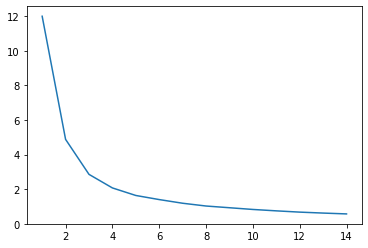

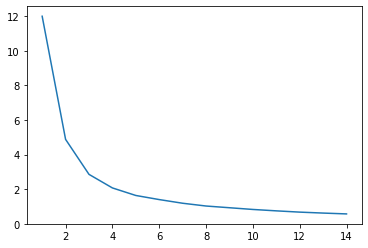

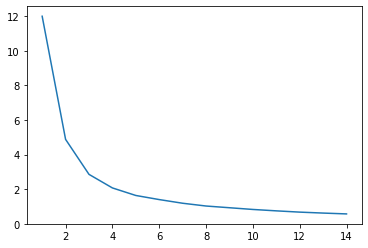

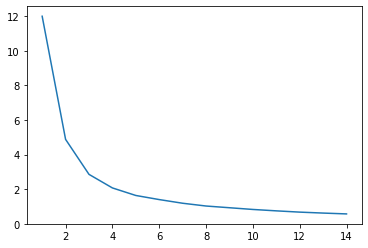

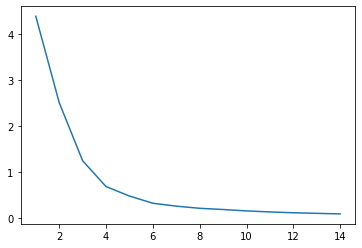

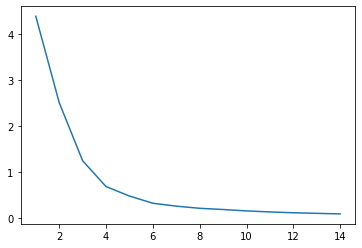

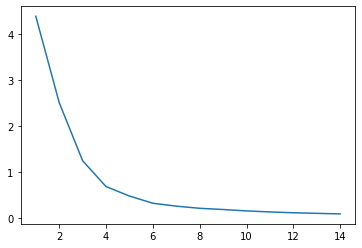

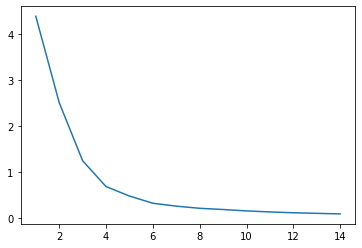

In [20]:
# Cluster for train_train HouseYearFix and DistrictId NO_FEATURE
ob_all.no_feature_list_cluster = []
whom1 = ob_train_train.data
whom2 = ob_train_test.data
whom3 = ob_test.data
cluster_name = ['DistrictId', 'HouseYearFix']
cluster_namber = [8,8]
type_ = 'no_feature_cluster'
for i, number in zip(cluster_name, cluster_namber):
  # print(i,number)
  for area_cluster in ['train_train']:
    find_within =  [ii for ii in ob_train_train.feature_list_district_no_feature if ii.split('-')[0] == i]
    ob_all.colect_empty(ob_train_train.data[find_within])
    # only_train = spleet_train_test_all(ob_train_train.data)                 ## задали ограничение по кластеризации
    ob_all.scalar(ob_train_train.data[ob_all.full_list])                                         ## ограничение по кластеризации 
    ob_all.data_MinMax[i] = ob_train_train.data[i]
    name = i + '_' + area_cluster + '_' + str(number)
    ob_all.kmean(ob_all.data_MinMax, whom1, i, number, name = name, type_= type_)   #раз
    ob_all.kmean(ob_all.data_MinMax, whom2, i, number, name = name, type_= type_)   #два
    ob_all.kmean(ob_all.data_MinMax, whom3, i, number, name = name, type_= type_)   #three
    ob_all.kmean(ob_all.data_MinMax, ob_all.data, i, number, name = name, type_= type_)   #three

    ob_all.no_feature_list_cluster.append(type_ + name)

    # # #перенос ключей на ob.data and ob_train_test
    ob_all.fake(whom1, whom1, name, type_= type_)
    ob_all.fake(whom1, whom2, name, type_= type_)
    ob_all.fake(whom1, whom3, name, type_= type_)
    ob_all.fake(whom1, ob_all.data, name, type_= type_)
    for iii in ['clust_price1Square', 'clust_Price']:
      ob_all.no_feature_list_cluster.append(type_ + name + iii)

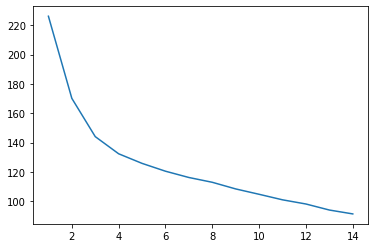

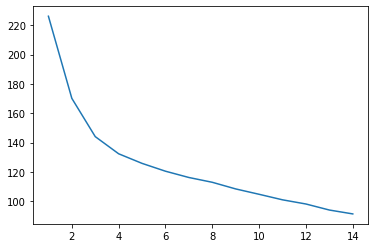

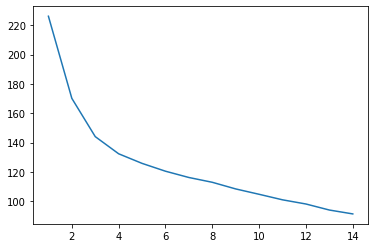

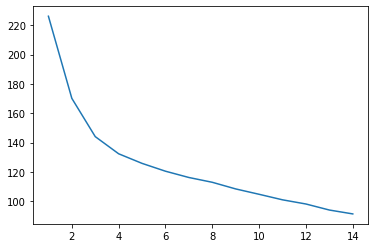

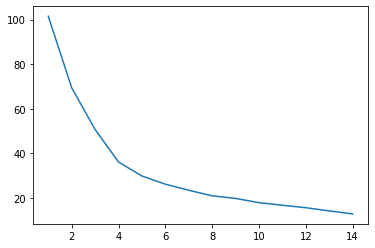

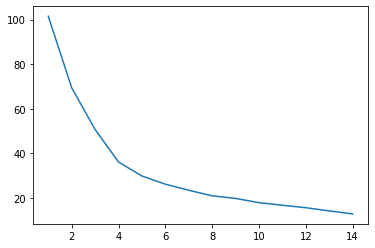

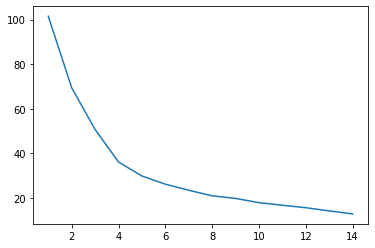

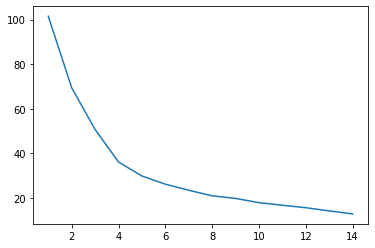

In [21]:
# Cluster for train_train HouseYearFix and DistrictId
ob_all.find_cluster_for_test_in_train = []
whom1 = ob_train_train.data
whom2 = ob_train_test.data
whom3 = ob_test.data
type_ = 'find_cluster_for_test_in_train'
cluster_name = ['DistrictId', 'HouseYearFix']
for i, number in zip(cluster_name, [8,8]):                                           #bpvtybnm yf 50,8
  # print(i,number)
  for area_cluster in ['train_train']:
    # find_within = [i for i in ob_all.feature_list_district if i.split('-')[0] == 'DistrictId']
    find_within =  [ii for ii in ob_all.feature_list_district if (ii.split('-')[0] == i and ii.split('-')[-1] == 'mean') or ii.split('-')[-1] == 'count']  #было с ворс
    # find_within = [i for i in ob_all.feature_list_district if (i.split('-')[0] == i and i.split('-')[-1] == 'mean') or i.split('-')[-1] == 'count'] #поменял как у бест
    ob_all.colect_empty(ob_all.data[find_within])
    # only_train = spleet_train_test_all(ob_all.data, 'train_train')                 ## задали ограничение по кластеризации  
    ob_all.scalar(ob_all.data[ob_all.full_list])                                         # ВСЕ МОЖЕТ ВСЕ!!!!
    ob_all.data_MinMax[i] = ob_all.data[i]
    name = i + '_' + area_cluster + '_' + str(number)
    ob_all.kmean(ob_all.data_MinMax, whom1, i, number, name = name, type_ = type_)   #раз
    ob_all.kmean(ob_all.data_MinMax, whom2, i, number, name = name, type_ = type_)   #два
    ob_all.kmean(ob_all.data_MinMax, whom3, i, number, name = name, type_ = type_)   #два
    ob_all.kmean(ob_all.data_MinMax, ob_all.data, i, number, name = name, type_ = type_)   #два

    ob_all.find_cluster_for_test_in_train.append(type_ + name)
    
    #перенос ключей на ob.data and ob_train_test
    ob_all.fake(whom1, whom1, name, type_ = type_)
    ob_all.fake(whom1, whom2, name, type_ = type_)
    ob_all.fake(whom1, whom3, name, type_ = type_)
    ob_all.fake(whom1, ob_all.data, name, type_ = type_)
    for iii in ['clust_price1Square', 'clust_Price']:
      ob_all.find_cluster_for_test_in_train.append(type_ + name + iii)

###First

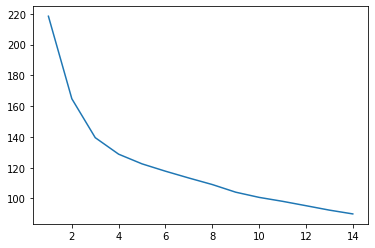

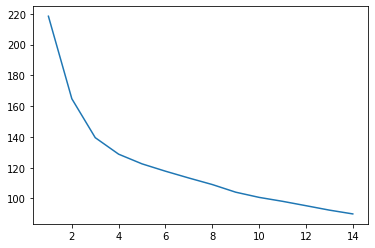

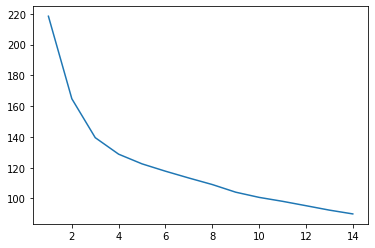

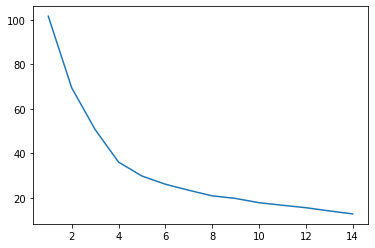

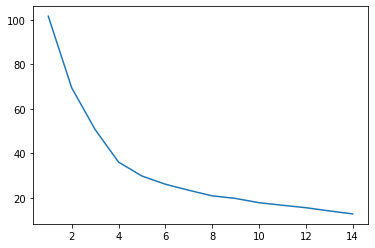

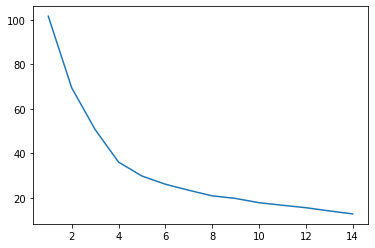

In [22]:
# Cluster for train_train HouseYearFix and DistrictId
ob_all.feature_list_cluster = []
whom1 = ob_train_train.data
whom2 = ob_train_test.data
whom3 = ob_test.data
type_ = 'cluster_'
cluster_name = ['DistrictId', 'HouseYearFix']
for i, number in zip(cluster_name, [8,8]):                                           #bpvtybnm yf 50,8
  # print(i,number)
  for area_cluster in ['train_train']:
    # find_within = [i for i in ob_all.feature_list_district if i.split('-')[0] == 'DistrictId']
    find_within =  [ii for ii in ob_all.feature_list_district if (ii.split('-')[0] == i and ii.split('-')[-1] == 'mean') or ii.split('-')[-1] == 'count']  #было с ворс
    # find_within = [i for i in ob_all.feature_list_district if (i.split('-')[0] == i and i.split('-')[-1] == 'mean') or i.split('-')[-1] == 'count'] #поменял как у бест
    ob_all.colect_empty(ob_all.data[find_within])
    only_train = spleet_train_test_all(ob_all.data, 'train_train')                 ## задали ограничение по кластеризации  МОЖЕТ ВСЕ!!!!
    ob_all.scalar(only_train[ob_all.full_list])                                         ## ограничение по кластеризации
    ob_all.data_MinMax[i] = ob_all.data[i]
    name = i + '_' + area_cluster + '_' + str(number)
    ob_all.kmean(ob_all.data_MinMax, whom1, i, number, name = name, type_ = type_)   #раз
    ob_all.kmean(ob_all.data_MinMax, whom2, i, number, name = name, type_ = type_)   #два
    ob_all.kmean(ob_all.data_MinMax, whom3, i, number, name = name, type_ = type_)   #два

    ob_all.feature_list_cluster.append(type_ + name)
    
    #перенос ключей на ob.data and ob_train_test
    ob_all.fake(whom1, whom1, name, type_ = type_)
    ob_all.fake(whom1, whom2, name, type_ = type_)
    ob_all.fake(whom1, whom3, name, type_ = type_)
    for iii in ['clust_price1Square', 'clust_Price']:
      ob_all.feature_list_cluster.append(type_ + name + iii)

### All


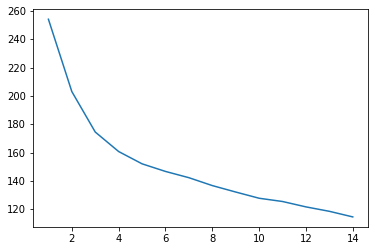

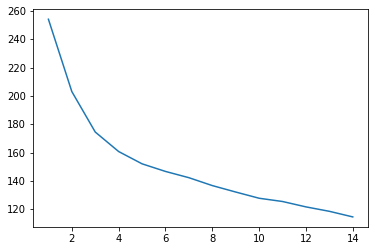

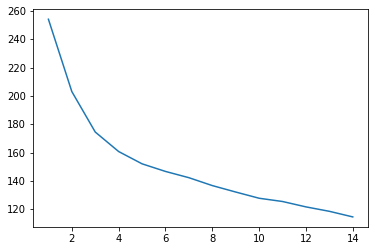

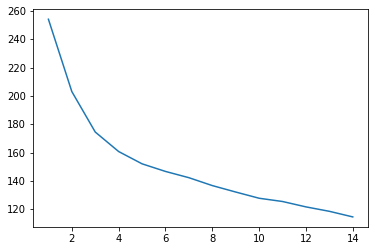

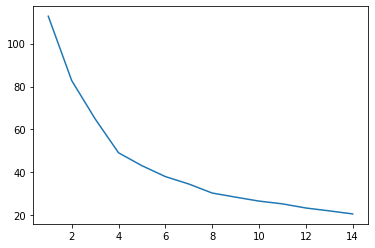

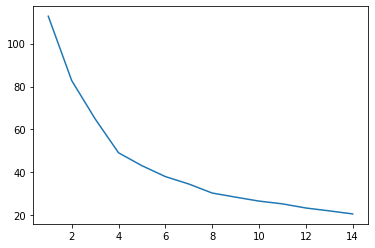

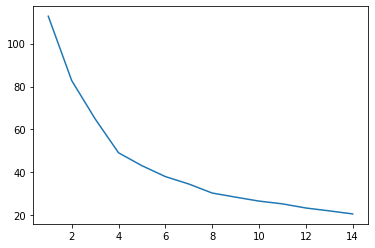

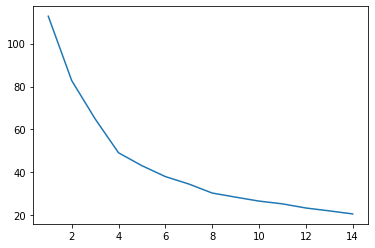

In [23]:
# Cluster for train_train HouseYearFix and DistrictId NO_FEATURE
ob_all.list_cluster_all = []
whom1 = ob_train_train.data
whom2 = ob_train_test.data
whom3 = ob_test.data
cluster_name = ['DistrictId', 'HouseYearFix']
cluster_namber = [8,8]
type_ = 'all_cluster'
for i, number in zip(cluster_name, cluster_namber):
  # print(i,number)
  for area_cluster in ['train_train']:
    find_within =  [ii for ii in ob_train_train.feature_list_district_for_anal if ii.split('-')[0] == i and ii.split('-')[2] != 'std'] + \
      [ii for ii in ob_all.feature_list_district if (ii.split('-')[0] == i and ii.split('-')[-1] == 'mean') or ii.split('-')[-1] == 'count']
    ob_all.colect_empty(ob_train_train.data[find_within])
    # only_train = spleet_train_test_all(ob_train_train.data)                 ## задали ограничение по кластеризации
    ob_all.scalar(ob_train_train.data[ob_all.full_list])                                         ## ограничение по кластеризации
    ob_all.data_MinMax[i] = ob_train_train.data[i]
    name = i + '_' + area_cluster + '_' + str(number)
    ob_all.kmean(ob_all.data_MinMax, whom1, i, number, name = name, type_= type_)   #раз
    ob_all.kmean(ob_all.data_MinMax, whom2, i, number, name = name, type_= type_)   #два
    ob_all.kmean(ob_all.data_MinMax, whom3, i, number, name = name, type_= type_)   #два
    ob_all.kmean(ob_all.data_MinMax, ob_all.data, i, number, name = name, type_= type_)   #два

    ob_all.list_cluster_all.append(type_ + name)

    # # #перенос ключей на ob.data and ob_train_test
    ob_all.fake(whom1, whom1, name, type_= type_)
    ob_all.fake(whom1, whom2, name, type_= type_)
    ob_all.fake(whom1, whom3, name, type_= type_)
    ob_all.fake(whom1, ob_all.data, name, type_= type_)
    for iii in ['clust_price1Square', 'clust_Price']:
      ob_all.list_cluster_all.append(type_ + name + iii)

In [24]:
for i in [ob_train_train, ob_train_test, ob_test]:
  i.data['Unique6'] = i.data['DistrictId'] * 1000000 + i.data['HouseYear'] * 100 + i.data['quant-HouseFloor'] 
  i.data['Unique7'] = i.data['DistrictId'] * 100 + i.data['HouseYear'] * 100000 + i.data['quant-HouseFloor'] 

# ModelRunOld

In [25]:
best = ['Square', 'DistrictId', 'HouseYear', 'roomSquare', 'Ecology_1',
       'LifeSquareFix', 'ShareLife', 'Social_3', 'HouseFloor', 'Social_2',
       'Floor',        
        'KitchenSquare', 
        'Social_1',
       'quant-DistrictId-Square-count', 'Shops_1', 'Helthcare_2',
       'historyDistrict', 'Shops_1Fix', 'RelativeFloor',
       'Healthcare1Empty', 'Rooms', 'Shops_3', 'RoomsFix', 'Shops_2',
       'Ecology_3', 'HouseYearFix', 'quant-roomSquare', 
       ] + \
['cluster_DistrictId_train_train_8',
 'cluster_DistrictId_train_train_8clust_price1Square',
 'cluster_DistrictId_train_train_8clust_Price',
 'cluster_HouseYearFix_train_train_8'] + \
 ['DistrictId-price1Square-mean', 'HouseYearFix-price1Square-mean'] + \
 ['no_feature_clusterDistrictId_train_train_8clust_price1Square', 'no_feature_clusterHouseYearFix_train_train_8clust_price1Square'] + \
 ['Unique', 'Unique1', 'Unique2','Unique3','Unique4','Unique5',] + \
 ['Unique6', 'Unique7'] 

In [26]:
%%time

target = 'Price'
for i in [best]:

  ob_train_train.create_X_train(i, target, 0)
  # ob_train_test.create_X_train(i, target, 10,)
  # ob_train_test.X_train.fillna(method='ffill', inplace = True)              
  ob_test.create_X_train(i, 'Price', 100, drop='kaggle')                 #kaggle     
  ob_test.X_train.fillna(method='ffill', inplace = True)

  datas = [ob_train_train.X_train, ob_test.X_train]                        #kaggle
  labels = ['DistrictId', 'Unique', 'Unique1']
  for data in datas:
    print(data.shape)
    for label in labels:
      category(data, label, type_ = 'category')

  for ii in [ob_train_train.X_train,
            ]:       

    model2 = LGBMRegressor(max_depth=25, #min_samples_leaf=10,  
                        n_estimators=150, random_state = 42)
    
    model1 = GradientBoostingRegressor(n_estimators=442, max_depth=5, min_samples_split=2,
                                              learning_rate=0.1, loss='ls', random_state=42)

    model3 = RandomForestRegressor(n_estimators=1442, max_depth=18, random_state=42, max_features = 'sqrt')

    model4 = GradientBoostingRegressor(criterion='mse',
                                     max_depth=6,
                                     min_samples_leaf=50,
                                     random_state=42,  
                                     n_estimators=2250, 
                                     max_features='sqrt', 
                                     loss='huber', 
                                     learning_rate=0.025)
                             
    modelSUM = VotingRegressor([('model1', model1), ('model2', model2), ('model3', model3), ('model4', model4)])

    cv_score = cross_val_score(modelSUM, ii, ob_train_train.y_train,                
                            scoring='r2', n_jobs=-1,
                            cv=KFold(n_splits=5, shuffle=True, random_state = 42))
    
    print(10*'**', 'Train_cross_val')
    mean = cv_score.mean()
    display(cv_score)
    std = cv_score.std()
    display('R2: {:.3f} +- {:.3f}'.format(mean, std))        


"убрали: Index([], dtype='object') число пропусков больше: 0"

"убрали: Index([], dtype='object') число пропусков больше: 100"

(10000, 43)
(5000, 43)
******************** Train_cross_val


array([0.7505046 , 0.7772294 , 0.7726048 , 0.77147793, 0.80216319])

'R2: 0.775 +- 0.016'

CPU times: user 2.29 s, sys: 320 ms, total: 2.61 s
Wall time: 7min 15s


# Submission 

In [27]:
%%time

file = 'final_submison.csv'
modelSUM = VotingRegressor([('model1', model1), ('model2', model2), ('model3', model3), ('model4', model4)]).fit(ob_train_train.X_train, ob_train_train.y_train)
Price = modelSUM.predict(ob_test.X_train)
pd.DataFrame({'Price': Price, 'id': ob_test.X_train.index}).to_csv('/content/drive/MyDrive/Colab Notebooks/course_work/data/submison/' + file, index=False)

CPU times: user 2min 15s, sys: 1.53 s, total: 2min 16s
Wall time: 2min 15s


In [ ]:
# model3.fit(ob_train_train_test.X_train, ob_train_train_test.y_train)
# importance = model3.feature_importances_
# col = pd.DataFrame([ob_train_train_test.X_train.columns, importance]).T.sort_values(1, ascending = False).head(100)[0].values
# display(pd.DataFrame([ob_train_train_test.X_train.columns, importance]).T.sort_values(1, ascending = False).head(100), col) 

# Рассуждения







In [ ]:
# Работы с выбросами: явно некорректные данные о цена за 1 метр связанны с неправильным определением площади жилья. Поправил увеличением Square в 10 и 100 раз.
# Если посомтреть распределение Price то она окажется похожей на гауссовскую, но это результать перемешивания квартир из разных районов.
# Если посомтреть на Price по какому то конкретному району сразу видна композиция из трех распределений (по числу комнат). Поэтому помимо Price использовал 
# показателя цены за 1 метр (price1Square), даже пробовал прогнозировать цену price1Square вместо Price, но r2 улучшились только при использовании
# простых моделей. Пример распределения Price и price1Square на дистрикте 27

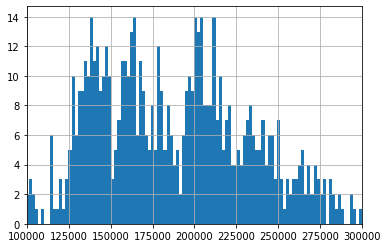

In [28]:
ob_train_train.data[ob_train_train.data['DistrictId'] == 1]['Price'].hist(bins = 200)
plt.xlim(100000, 300000)
plt.show()

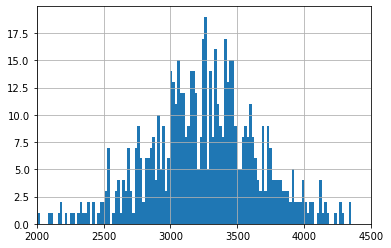

In [29]:
ob_train_train.data[ob_train_train.data['DistrictId'] == 1]['price1Square'].hist(bins = 200)
plt.xlim(2000, 4500)
plt.show()

In [ ]:
# Работа с фичами.
# Сгенерировал более 600 фичей на схеме:
# Группируем первоначальные фичи по 'DistrictId' или 'HouseYearFix' и вычислям их 'mean', 'min', 'max', 'std', 'sum'. Можно было выйти за пределы 'DistrictId' и 'HouseYearFix',
# но к примеру "средний показатель Ecology_1 для квартир из домов этажности 10" - выглядит довольно бессмысленно. Тем более существует нерешенная мною проблема
# отбора фичей, так что к чему генериовать не совсем осмысленные фичи, если даже с осмысленными не получается разобраться.
# Все эти сгенерированные фичи будут отличаться в зависимости от взятой выборки. Поэтому все сгенерированные фичи считал для 4 разных наборов:
#  all(15000 примеров), train_train (6500 примеров), train_test(3500), test(5000).
# Для удобства все наборы фичей разбил на группы:
# self.feature_list_district
# self.feature_list_district_no_feature
# self.feature_list_district_for_anal
# self.feature_list_outer
# self.feature_list_fill
# self.feature_list_cluster
# Очевидно значения по дистриктам имеют наиболее важное значение, тем более что данные скорей всего по американскому городу, где очень важно понятие neighborhood.


In [ ]:
# Средняя цена по дистрикту отражает уровень престижности района. Количество предложений по дистриктам о соотношении спроса-предложения. 
# То же самое можно сказать и о годах, так как каждому году соответствует опеределенный уровень строительной техники, моды, котоаря может быть более или менее удачной. 
# Например бросается в глаза большое предложение квартир 1977 года постройки, причем уровень цен значительно ниже соседних: за 1976 и 1978.
# Но при работе с такими фичами есть 2 проблемы. Во первых на тестовых данных присутствуют новые дистрикты (решил кластеризацией, на основе 
# которой присвоил отсутствующим дистриктам номера наиболее похожих их тестовых примеров). Вторая проблема в малом числе примеров для многих дистриктов, что
# делает поулченные показатели во многом случайными. Это выражатеся в частности в том что r2 для квартир из дистриктов со многими предложениями
# превышала 0,8, в то время как для квартир из дистриктов с редкими примерами r2 колебалась вокруг 0,65.
# Пробовал решить проблему созданием класса "class_integer" чтобы на основе кластеризации укрупнить схожие мелкие дистрикты, но вразумительных улучшений не было. 
# По той же схеме думал разбить некоторые большие дистрикты на поддистрикты. Наличие поддистриктов в некоторых особо крупных 
# дистриктов очевидно. Например если взять 23 дистрикт и разбить его на 2 кластера по ['Social_1', 'Shops_1'] и затем глянуть распределение 
# price1Square, то они очевидно будут разными:


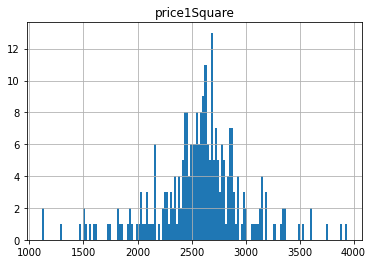

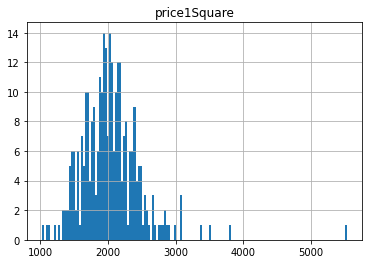

In [30]:
int = integrate()
feature = ['Social_1', 'Shops_1']
DATA = ob_train_train.data[(ob_train_train.data['DistrictId'] == 23)]
whoms = [ob_train_train.data]
max_clust = 8
n_clusters = 2
type_ = 'diff_dis'
print = 'print'
int.kmean_simple(DATA = DATA, whoms = whoms, feature = feature, n_clusters = n_clusters, max_clust = max_clust, type_ = type_, print_ = 'none')
ob_train_train.data[(ob_train_train.data['DistrictId'] == 23)&(ob_train_train.data['combine_clust_2_diff_dis'] == 0)][['price1Square']].hist(bins = 150)
ob_train_train.data[(ob_train_train.data['DistrictId'] == 23)&(ob_train_train.data['combine_clust_2_diff_dis'] == 1)][['price1Square']].hist(bins = 150)
plt.show()

In [ ]:
# Частично решил проблему неоднородности внутри дистриктов кластеризацией по дистриктам. Тут опять стоит выбор какие именно показатели брать для кластеризации и какой набор данных использовать, 
# и количества кластеров.
# Я выбрал 8 кластеров, и для кластеризации выбирал первоначальные фичи, но также попробовал кластеризацию с учетом Price.
# Отдельно попробовал найти квартиры находящиеся в 1 доме или одинаковых домах
# Очевидно что присутствуют типовые дома, которые можно отловить по разным группировками, например: дистрикт/этажность_дома/год_постройки_дома. 
#  Например:


In [ ]:
# Общее число сгенерированных фичей превысило 600 штук. Я попробовал отбирать на основе корреляции, RandomForest, rfecv (class Feature_Selection()), но что то оказалось 
# негодным, а что то требовало слишком много времени, поэтмоу занялся "комбинаторийкой на коленках" по принципу логичности и здравого смысла. Модель обучал на 43 фичах 
# Искать лучшие гиперпараметры модели по GreedSerch не стал, предпочел VotingRegressor из 4 моделей с параметрами взятыми с неба.

In [ ]:
# Если говорить о наборе данных, то можно выявить некоторые закономерности. Например падение стоимости за квадрат по мере увеличения размера квартиры:

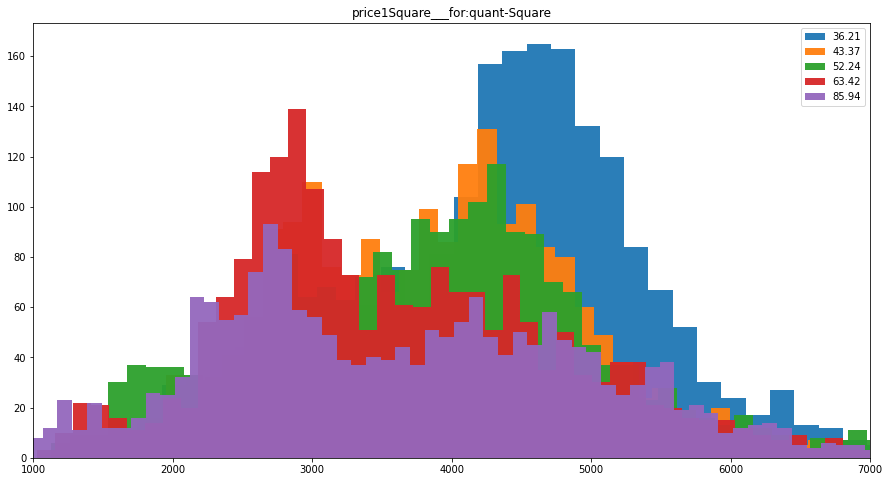

In [32]:
price_ = 'price1Square'
DATA_ = ob_train_train.data
name = ""
bins = 75
for quant_ in ['quant-Square']:
  plot_quant(quant_, 'price1Square', DATA_, name = '')

In [ ]:
# Price1Square падает по мере увеличения размера квартиры за исключением последне квантили, тут речь идет о сверхбогатых (толстых хвостах), которые готовы переплачивать:

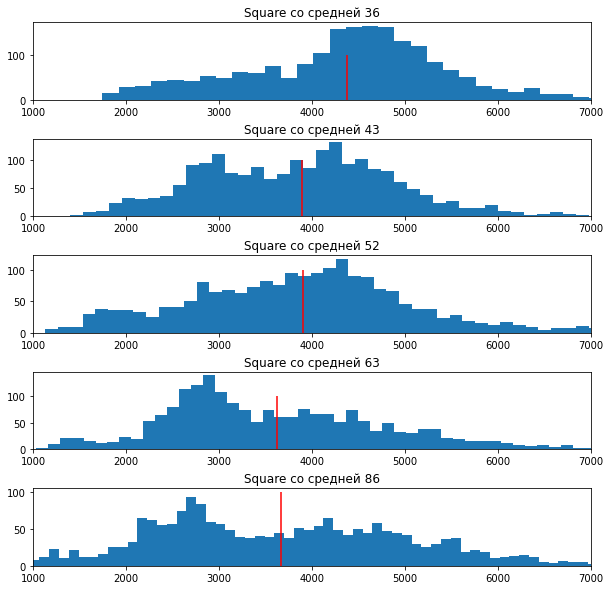

In [33]:
for quant_ in ['quant-Square']:
  plot_quant_one(quant_, price_, DATA_, name = '')

In [ ]:
# Можно наблюдать некоторые тенденции. Например падение средней площади квартиры с 1940 до 1970 (эпоха "американских хрущевок"), с последющим ростом до 2010 
# и стабилизацией после:

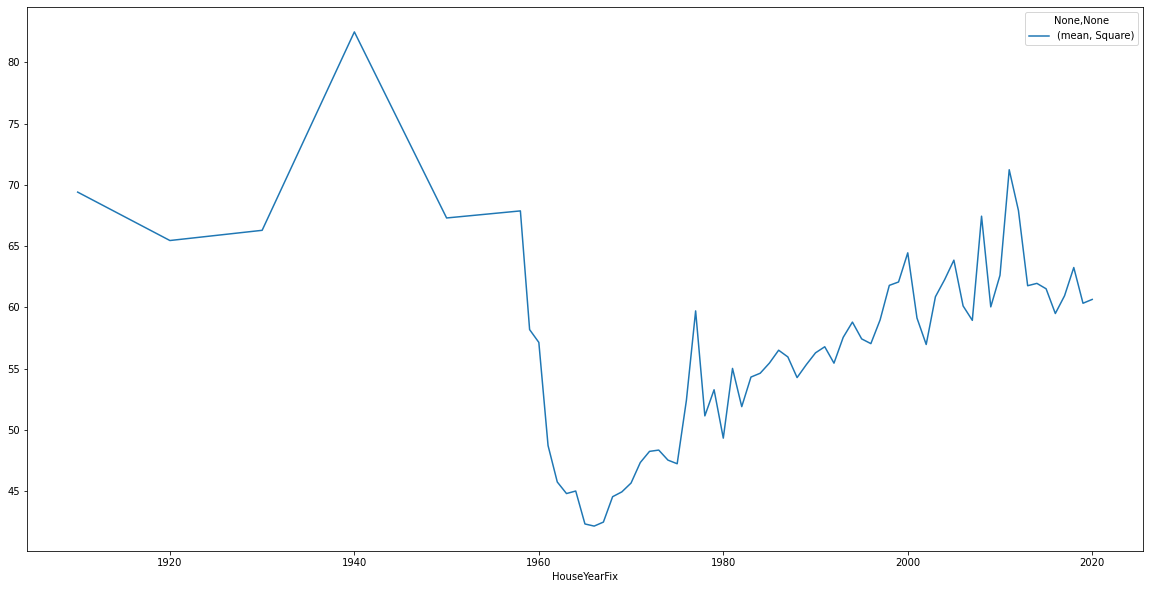

In [34]:
aggfunc = ['mean']
DATA__ = ob_train_train_test.data
pd.pivot_table(DATA__,
               index = ['HouseYearFix'],
               values = 'Square',
               aggfunc = aggfunc
               ).plot(figsize=(20,10))

plt.show()

In [ ]:
# При этом средняя площадь комнаты растет постоянно, даже после 2010 года, что видимо связанно с модой на квартиры студии.

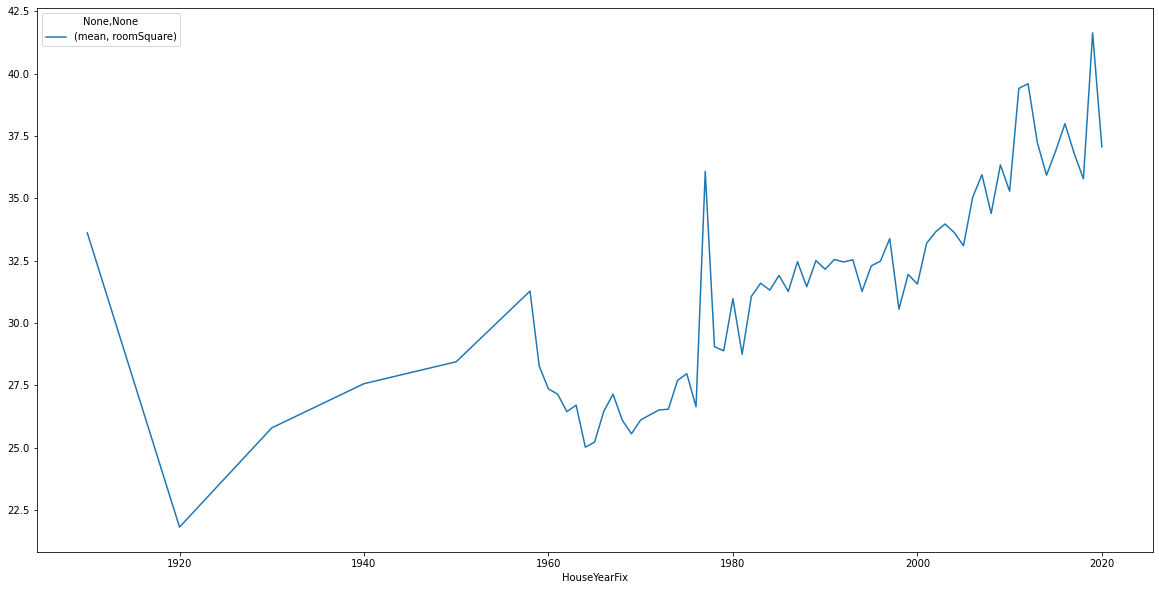

In [ ]:
aggfunc = ['mean']
DATA__ = ob_train_train_test.data
pd.pivot_table(DATA__,
               index = ['HouseYearFix'],
               values = 'roomSquare',
               aggfunc = aggfunc
               ).plot(figsize=(20,10))
plt.show()

In [ ]:
# Тут видим что так и есть - после 2000 имеется явный тренд на уменьшение числа комнат

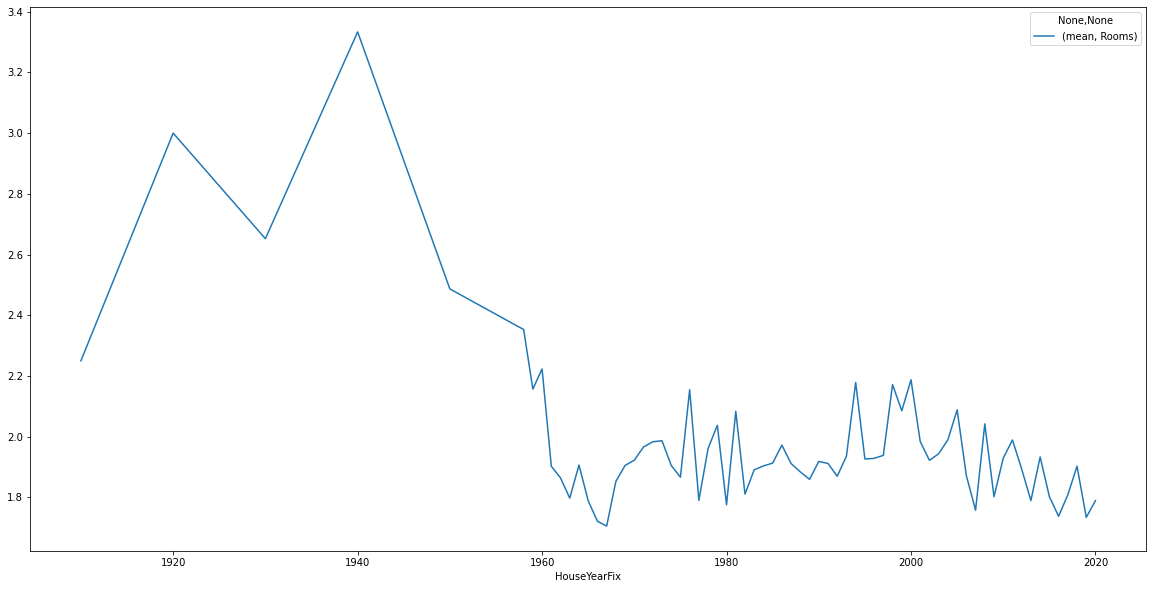

In [ ]:
aggfunc = ['mean']
DATA__ = ob_train_train_test.data
pd.pivot_table(DATA__,
               index = ['HouseYearFix'],
               values = 'Rooms',
               aggfunc = aggfunc
               ).plot(figsize=(20,10))
plt.show()